# ***Распознавание текстов, сгенерированных Chat-GPT***


В рамках IT-трека Академии научного наставничества ставится задача создания модели для распознавание сгенерированных Chat-GPT текстов.

Доступно соревнование на [kaggle](https://www.kaggle.com/competitions/chat-gpt-generated-text-detection).

## Считывание данных

Для удобства будем загружать данные с гугл-диска

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

path="/content/gdrive/MyDrive/Академия научного наставничества IT/"

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np

train=pd.read_csv(path+"train.csv")
train

,id,text,author
0,3161,A new service called Twitter Alerts has been a...,chatgpt
1,24964,Swansea City fans will be delighted to hear th...,chatgpt
2,22861,Ready to go: Ross McCormack took part in Fulha...,person
3,68204,Penn Station is the busiest transportation hub...,chatgpt
4,10289,"The government, which had been the guarantor o...",chatgpt
...,...,...,...
84595,73004,"The cone-shaped machine, decelerated by a sequ...",chatgpt
84596,42153,CNN Student News offers a unique opportunity f...,chatgpt
84597,25941,"Cornelius Jefferson, a 33-year-old resident of...",chatgpt
84598,37518,Europe is experiencing a growing tendency away...,chatgpt


In [ ]:
test=pd.read_csv(path+"test.csv")
test

,id,text
0,68113,There have been 50 online bomb threats made si...
1,19660,"Haifa Port, situated on the Mediterranean coas..."
2,79151,Connecticut Senator Richard Blumenthal had a s...
3,8415,Ohio's governor on Friday signed an executive ...
4,12307,"Kadaram was not the only target of the attack,..."
...,...,...
9394,84010,It's likely someone from Hong Kong has just be...
9395,241,"Calvin Veltman undertook, for the National Cen..."
9396,24258,I was so paranoid I might find a lump that I e...
9397,26109,"By . Laura Powell . PUBLISHED: . 16:13 EST, 3 ..."


## Исследование данных

**Проверим баланс классов**

В задаче классификации данные называются несбалансированными (Imbalanced Data), если в обучающей выборке доли объектов разных классов существенно различаются, также говорят, что «классы не сбалансированы».

<BarContainer object of 2 artists>

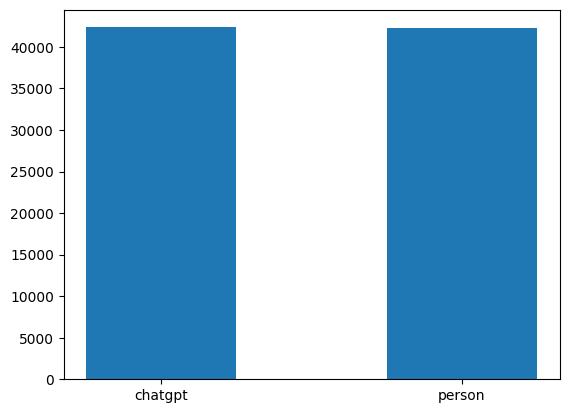

In [ ]:
import matplotlib.pyplot as plt

groups = ["chatgpt", "person"]
counts = [len(train.loc[train["author"]=="chatgpt"]), len(train.loc[train["author"]=="person"])]

plt.bar(groups, counts, width=0.5)

Рассмотрим распределение текстов по количеству предложений. Подобная информация о данных также может быть использована для классификации.

<Axes: >

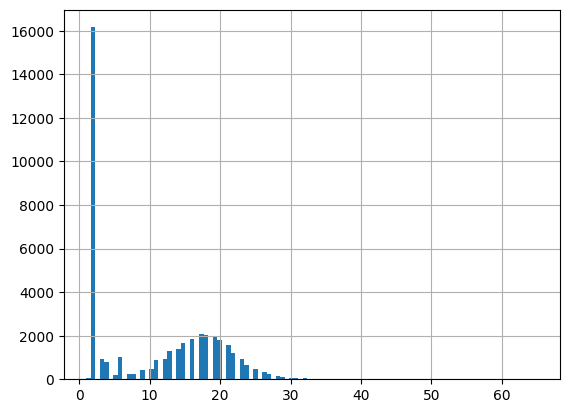

In [ ]:
seq_len = [len(str(i).split(".")) for i in train.loc[train["author"]=="chatgpt"]["text"]]
pd.Series(seq_len).hist(bins = 100)

<Axes: >

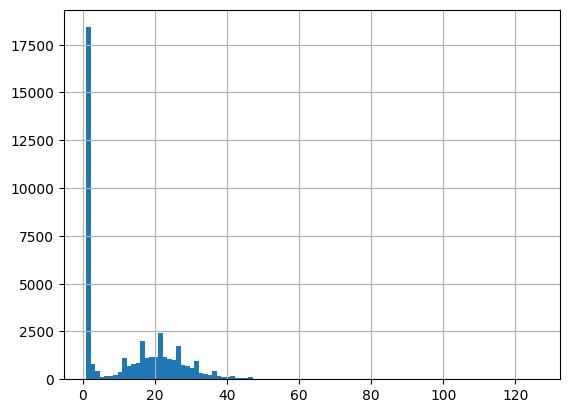

In [ ]:
seq_len = [len(str(i).split(".")) for i in train.loc[train["author"]=="person"]["text"]]
pd.Series(seq_len).hist(bins = 100)

Добавим информацию о числе предложений в наш DataFrame

In [ ]:
seq_len = [len(str(i).split(".")) for i in train["text"]]
train.loc[:, "points"] = seq_len

seq_len = [len(str(i).split(".")) for i in test["text"]]
test.loc[:, "points"] = seq_len

Количество слов в текстах

<Axes: >

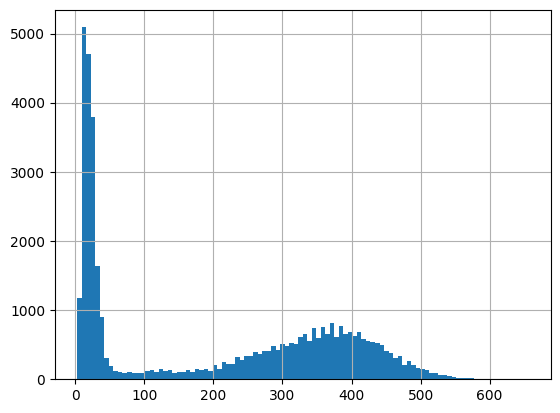

In [ ]:
seq_len = [len(str(i).split()) for i in train.loc[train["author"]=="chatgpt"]["text"]]
pd.Series(seq_len).hist(bins = 100)

<Axes: >

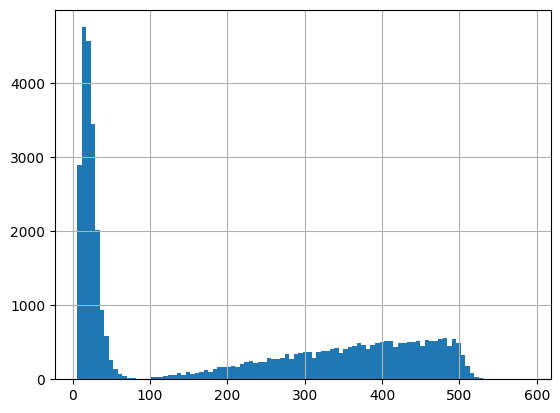

In [ ]:
seq_len = [len(str(i).split()) for i in train.loc[train["author"]=="person"]["text"]]
pd.Series(seq_len).hist(bins = 100)

In [ ]:
seq_len = [len(str(i).split()) for i in train["text"]]
train.loc[:, "words"] = seq_len

seq_len = [len(str(i).split()) for i in test["text"]]
test.loc[:, "words"] = seq_len

In [ ]:
train

,id,text,author,points,words
0,3161,A new service called Twitter Alerts has been a...,chatgpt,12,232
1,24964,Swansea City fans will be delighted to hear th...,chatgpt,14,280
2,22861,Ready to go: Ross McCormack took part in Fulha...,person,2,19
3,68204,Penn Station is the busiest transportation hub...,chatgpt,2,19
4,10289,"The government, which had been the guarantor o...",chatgpt,2,23
...,...,...,...,...,...
84595,73004,"The cone-shaped machine, decelerated by a sequ...",chatgpt,6,20
84596,42153,CNN Student News offers a unique opportunity f...,chatgpt,10,231
84597,25941,"Cornelius Jefferson, a 33-year-old resident of...",chatgpt,10,170
84598,37518,Europe is experiencing a growing tendency away...,chatgpt,2,23


In [ ]:
train.loc[train["author"]=="chatgpt", 'author']=0
train.loc[train["author"]=="person", 'author']=1
train

,id,text,author,points,words
0,3161,A new service called Twitter Alerts has been a...,0,12,232
1,24964,Swansea City fans will be delighted to hear th...,0,14,280
2,22861,Ready to go: Ross McCormack took part in Fulha...,1,2,19
3,68204,Penn Station is the busiest transportation hub...,0,2,19
4,10289,"The government, which had been the guarantor o...",0,2,23
...,...,...,...,...,...
84595,73004,"The cone-shaped machine, decelerated by a sequ...",0,6,20
84596,42153,CNN Student News offers a unique opportunity f...,0,10,231
84597,25941,"Cornelius Jefferson, a 33-year-old resident of...",0,10,170
84598,37518,Europe is experiencing a growing tendency away...,0,2,23


При работе с текстами знаки препинания обычно удаляются, чтобы немного "очистить" данные.

In [ ]:
punctuation_signs = list("?:!.,;")
for punct_sign in punctuation_signs:
    train['text'] = train['text'].str.replace(punct_sign, '')
    test['text'] = test['text'].str.replace(punct_sign, '')

<ipython-input-17-03ad3a5b4729>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train['text'] = train['text'].str.replace(punct_sign, '')
<ipython-input-17-03ad3a5b4729>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['text'] = train['text'].str.replace(punct_sign, '')
<ipython-input-17-03ad3a5b4729>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test['text'] = test['text'].str.replace(punct_sign, '')


Помимо удаления знаков препинания часто используется исключение всех неалфавитных символов

In [ ]:
import re

def del_s(df, col):
    text_list = []
    for row in range(len(df)):
        lemmatized_list = []
        text = df.iloc[row][col]
        text=re.sub("[^a-zA-Z]"," ",text)
        text_list.append(text)
    return text_list
train["text"]=del_s(train, "text")
test["text"]=del_s(test, "text")

## Векторизация

**Перемешаем данные**

Это не так важно для обучения, а делается с целью оставить часть данных на тестирование и оценки точности решения задачи перед отправкой решения на kaggle

In [ ]:
from sklearn.utils import shuffle
train = shuffle(train)
train

,id,text,author,points,words
67900,76280,That description is similar to something Ivins...,1,2,21
43047,90514,In the Cape Colony had taken over the po...,0,2,37
73869,88979,Gaining just five pounds can lead to an increa...,1,24,471
71947,72033,Experts advise that the exact numbers are impr...,0,2,20
80637,89337,Despite the fact that the Primary Chronicle do...,0,6,128
...,...,...,...,...,...
57970,28961,Tucson is the rd largest city and th large...,0,2,19
55573,9469,As an academic field philosophy of education ...,1,5,30
1940,54685,By Emma Thomas PUBLISHED EST ...,1,24,391
40183,89699,Bahrain s king reshuffled his cabinet Saturday...,1,25,445


In [ ]:
import nltk
import re

nltk.download("stopwords") # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


***Токенизация*** - метод позволяющий разделить текст на так называемые токены, то есть на слова или предложения.

***Лемматизация*** - приведение словоформы к лемме — ее нормальной (словарной) форме. Другими словами, лемматизация схожа с выделением основы каждого слова в предложении. Она обычно выполняется простым поиском форм в таблице.

***Стемминг*** - это процесс обрезания конца или начала слов с целью удаления аффиксов (лексических дополнений к корню слова).

***Векторизация текста*** - преобразование текста в численную форму. Алгоритмы машинного обучения не умеют работать с текстом, поэтому необходимо превратить текст в цифры.

Часть информации при образовании текста в численную форму теряется. Качественная работа с данными позволяет получить хороший результат с самыми простыми алгоритмами классификации. И наоборот, если будет потерено много информации при предобработке, то даже самые сложные алгоритмы не помогут.

Сначала проведём токенизацию, разделив каждый текст на отдельные слова, а затем приведём каждое слово к лемме

In [ ]:
def func(df, col):
    wordnet_lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_text_list = []
    for row in range(len(df)):
        lemmatized_list = []
        text = df.iloc[row][col]
        text_words = text.split(" ")
        for word in text_words:
            word_norm = wordnet_lemmatizer.lemmatize(word)
            lemmatized_list.append(word_norm)
        lemmatized_text = " ".join(lemmatized_list)
        lemmatized_text_list.append(lemmatized_text)
    return lemmatized_text_list


train["text"] = func(train, "text")
test["text"] = func(test, "text")

In [ ]:
all_data=pd.concat([train, test])
all_data

,id,text,author,points,words
67900,76280,That description is similar to something Ivins...,1,2,21
43047,90514,In the Cape Colony had taken over the po...,0,2,37
73869,88979,Gaining just five pound can lead to an increas...,1,24,471
71947,72033,Experts advise that the exact number are impre...,0,2,20
80637,89337,Despite the fact that the Primary Chronicle do...,0,6,128
...,...,...,...,...,...
9394,84010,It s likely someone from Hong Kong ha just bea...,NaN,35,360
9395,241,Calvin Veltman undertook for the National Cen...,NaN,2,28
9396,24258,I wa so paranoid I might find a lump that I ev...,NaN,2,16
9397,26109,By Laura Powell PUBLISHED EST ...,NaN,27,388


Модуль CountVectorizer преобразовывает входной текст в матрицу, значениями которой являются количества вхождения данного ключа(слова) в текст.

Получается, так называемый, "мешок слов".

In [ ]:
c

In [ ]:
!pip install autokeras

  Using cached autokeras-1.1.0-py3-none-any.whl (148 kB)
  Using cached keras_tuner-1.3.5-py3-none-any.whl (176 kB)
  Using cached keras_nlp-0.6.1-py3-none-any.whl (573 kB)
  Using cached keras_core-0.1.4-py3-none-any.whl (880 kB)
  Using cached tensorflow_text-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.5 MB)
  Using cached kt_legacy-1.0.5-py3-none-any.whl (9.6 kB)
  Using cached namex-0.0.7-py3-none-any.whl (5.8 kB)
  Using cached tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (524.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 39.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting un

In [ ]:
import autokeras as ak
clf = ak.TextClassifier(
    overwrite=True, max_trials=5
)  # It only tries 1 model as a quick demo.
# Feed the text classifier with training data.
clf.fit(train["text"].to_numpy(), train["author"], epochs=2, batch_size=256)

Trial 1 Complete [00h 11m 50s]
val_loss: 0.2873871922492981

Best val_loss So Far: 0.2873871922492981
Total elapsed time: 00h 11m 50s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
transformer       |vanilla           |text_block_1/block_type
0                 |0                 |classification_head_1/dropout
adam              |adam              |optimizer
0.001             |0.001             |learning_rate
none              |None              |text_block_1/transformer_1/pretraining
32                |None              |text_block_1/transformer_1/embedding_dim
2                 |None              |text_block_1/transformer_1/num_heads
32                |None              |text_block_1/transformer_1/dense_dim
0.25              |None              |text_block_1/transformer_1/dropout

Epoch 1/2
265/265 [==============================] - 29s 98ms/step - loss: 0.5095 - accuracy: 0.7107 - val_loss: 0.3865 - val_accuracy: 0.8063
Epoch 2/2
 90/265 [=========>....

In [ ]:
with tf.device('/GPU:0'):


Идея TfidfVectorizer аналогична CountVectorizer, но при этом учитывается ещё и непосрественную важность каждого слова.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)
matrix = tfidf.fit_transform(all_data["text"]).toarray()

In [ ]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import tensorflow as tf
with tf.device('/GPU:0'):

  vocab_size = 10000 # количество уникальных слов в словаре
  embedding_dim = 1024 # число параметров после эмбеддинга
  max_length = 2000 # максимальная длина новости

  model = tf.keras.Sequential([
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid') # 1 - число выходных нейронов (для задачи бинарной классификации достаточно одного нейрона)
  ])
  model.compile(loss='binary_crossentropy',
                metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)],
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00004))


In [ ]:
with tf.device('/GPU:0'):
  num_epochs = 20
  model.fit(tf.convert_to_tensor(list(matrix[:len(train)])), # X
            tf.convert_to_tensor(list(train["author"].to_numpy())),# y
            batch_size=128,
            validation_split=0.1,
            epochs=num_epochs)

Epoch 1/20
595/595 [==============================] - 13s 20ms/step - loss: 0.5749 - binary_accuracy: 0.7677 - val_loss: 0.4138 - val_binary_accuracy: 0.8138
Epoch 2/20
595/595 [==============================] - 12s 20ms/step - loss: 0.3571 - binary_accuracy: 0.8317 - val_loss: 0.3391 - val_binary_accuracy: 0.8301
Epoch 3/20
595/595 [==============================] - 12s 20ms/step - loss: 0.3122 - binary_accuracy: 0.8503 - val_loss: 0.3217 - val_binary_accuracy: 0.8396
Epoch 4/20
595/595 [==============================] - 12s 20ms/step - loss: 0.2929 - binary_accuracy: 0.8609 - val_loss: 0.3148 - val_binary_accuracy: 0.8447
Epoch 5/20
595/595 [==============================] - 12s 20ms/step - loss: 0.2808 - binary_accuracy: 0.8673 - val_loss: 0.3126 - val_binary_accuracy: 0.8466
Epoch 6/20
595/595 [==============================] - 11s 19ms/step - loss: 0.2715 - binary_accuracy: 0.8725 - val_loss: 0.3108 - val_binary_accuracy: 0.8485
Epoch 7/20
595/595 [==============================] 

In [ ]:
features_test = tf.convert_to_tensor(list(matrix[len(train):]))
with tf.device('/GPU:0'):

  res=model.predict(features_test)
total=[round(i[0]) for i in res]
test.loc[:, "author"]=total

294/294 [==============================] - 1s 3ms/step


In [ ]:
output=test.drop(columns=["text", "words", "points"])
output.loc[:, "author"] = total
output

,id,author
0,68113,0
1,19660,0
2,79151,0
3,8415,1
4,12307,1
...,...,...
9394,84010,1
9395,241,0
9396,24258,0
9397,26109,0


In [ ]:
from google.colab import files
output.to_csv("solution.csv", index=False)

files.download("solution.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Добавляем в каждый столбец информацию о количестве слов и предложений в тексте.

In [ ]:
for i in range(len(train)):
  np.append(matrix[i],train.iloc[i]["points"])
  np.append(matrix[i],train.iloc[i]["words"])
for i in range(len(test)):
  np.append(matrix[len(train)+i],test.iloc[i]["points"])
  np.append(matrix[len(train)+i],test.iloc[i]["words"])

## Обучение модели

Будем использовать логистическую регресиию.

Про другие алгоритмы классификаии в библиотеке sklearn можно прочитать [здесь](https://tproger.ru/translations/scikit-learn-in-python/), а также в [документации sklearn](https://scikit-learn.ru/category/supervised_learning/).

In [ ]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
model=LogisticRegression()
model.fit(X=matrix[:len(train)-5000], y=train["author"].to_numpy().astype('int')[:-5000])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X=matrix[:len(train)-5000], y=train["author"].to_numpy().astype('int')[:-5000])

Тестируем модель, на части данных, которые не были использованы для обучения и строим ConfusionMatrix

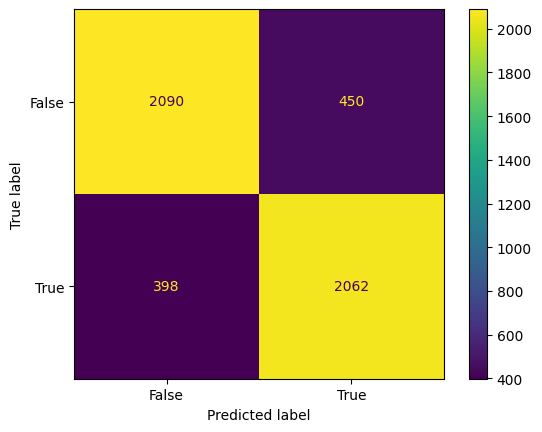

In [ ]:
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_pred=model.predict(matrix[len(train)-5000:len(train)])
y_true=train["author"].to_numpy().astype('int')[-5000:]

confusion = confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = [False, True])

cm_display.plot()
plt.show()

Считаем Accuracy и F1-score

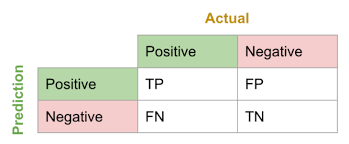

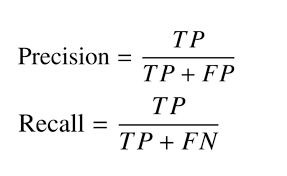

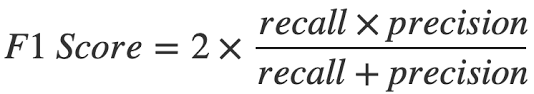

In [ ]:
print(sklearn.metrics.accuracy_score(y_true, y_pred))
print(sklearn.metrics.f1_score(y_true, y_pred))

0.8304
0.8294448913917941


Готовим результат для отправки на kaggle

In [ ]:
res=model.predict(matrix[len(train):])

In [ ]:
output=test.drop(columns=["text"])
output.loc[:, "author"] = res
output

,id,points,words,author
0,588759,2,20,0
1,847764,2,18,1
2,598557,2,19,1
3,269963,3,8,0
4,415279,2,19,0
...,...,...,...,...
5147,382864,2,25,1
5148,541485,2,33,0
5149,37738,3,29,0
5150,248564,2,15,0


In [ ]:
output=test.drop(columns=["text","words","points"])
output.loc[:, "author"] = res
output

,id,author
0,68113,1
1,19660,0
2,79151,0
3,8415,1
4,12307,1
...,...,...
9394,84010,0
9395,241,0
9396,24258,1
9397,26109,1


In [ ]:
from google.colab import files
output.to_csv("solution.csv", index=False)

files.download("solution.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>